In [1]:
import json

from autorank import (
    autorank,
    create_report,
    latex_table,
)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns

### Load the data

In [2]:
tasks_df = pd.read_csv("../assets/tasks.csv")
tasks_df = tasks_df.loc[tasks_df["Task type"].isin(["Binary classification", "Multi-class classification", "Multi-label classification", "Regression"])]

In [3]:
models_df = pd.read_csv("../assets/models.csv")

In [4]:
results_paths = {
    "Open-source":  "./results/finetuning/{task_name}/{model_name}/test/test_results.json",    
    "Proprietary": "./results/text_generation/{task_name}/{model_name}/test_results.json",
    "Baseline": "./results/{model_name}/{task_name}/test/test_results.json",
}

In [5]:
metrics = {
    "Regression": "smape",
    "NER": "overall_f1",
    "MLM": "accuracy",
    "default": "f1_macro"
}

In [6]:
all_results = []

for i, task in tasks_df.iterrows():
    for j, model in models_df.iterrows():
        path_ = results_paths[model["Model type"]].format(
                task_name=task["Task ID"],
                model_name=model["Model ID"]
            )

        try:
            with open(path_, "r") as f:
                results = json.load(f)
                results = {k.replace("eval_", ""): v for k, v in results.items()}
            
            if task["Task type"] in metrics.keys():
                metric = metrics[task["Task type"]]
            else:
                metric = metrics["default"]

            row = task.to_dict() | model.to_dict()
            row["Score"] = results[metric]
            all_results.append(row)
        except FileNotFoundError:
            print("Error analyzing file in path:", path_)

all_results_df = pd.DataFrame(all_results)

# Calculating the inverse value of sMAPE (1-sMAPE)
all_results_df["Score"] = all_results_df.apply(lambda x: (1 - x["Score"]) if x["Task type"] == "Regression" else x["Score"], axis=1)

In [7]:
all_results_df.shape

(390, 11)

In [8]:
all_results_df.sample(5)

,Task type,Task ID,Activity,Model ID,Model name,Model architecture,Model size,Number of parameters,Domain adaptation,Model type,Score
212,Multi-class classification,sentiment,Management,ModernBERT-base,ModernBERT base,Encoder-only,Million params.,149014272.0,Generalist,Open-source,0.775956
236,Multi-label classification,comment_type_java,Development,roberta-base,RoBERTa base,Encoder-only,Million params.,124645632.0,Generalist,Open-source,0.562870
104,Multi-class classification,closed_question,Management,bert-base-cased,BERT base,Encoder-only,Million params.,108310272.0,Generalist,Open-source,0.544584
345,Multi-label classification,smell_doc,Quality assurance,gpt2-medium,GPT-2 medium,Decoder-only,Million params.,354823168.0,Generalist,Open-source,0.265614
13,Binary classification,bug_issue,Quality assurance,t5-base,T5 base,Encoder-decoder,Million params.,222903552.0,Generalist,Open-source,0.836262


### Run Autorank

In [9]:
all_results_pivot_df = all_results_df.pivot(index="Task ID", columns="Model name", values="Score")
all_results_pivot_df = all_results_pivot_df.reset_index(drop=True)

In [10]:
all_results_pivot_df.sample(5)

Model name,BERT base,BERT large,Claude 3.5 Sonnet,CodeBERT base,CodeLlama 7b,CodeT5+ 220m,CodeT5+ 770m,FastText,GPT-2 large,GPT-2 medium,...,ModernBERT large,RoBERTa base,RoBERTa large,StarCoder2 3b,StarCoder2 7b,T5 3b,T5 base,T5 large,T5 small,TFIDF-XGBoost
0,0.864294,0.871582,0.806193,0.871281,0.897711,0.864313,0.870966,0.798480,0.882901,0.873954,...,0.885166,0.867603,0.885040,0.887075,0.875921,0.868724,0.836262,0.859373,0.653903,0.775906
5,0.565518,0.617012,0.525735,0.436666,0.743077,0.501702,0.483785,0.605108,0.692764,0.362450,...,0.644217,0.191948,0.228403,0.692605,0.761601,0.380437,0.273802,0.286903,0.337556,0.665602
7,0.785976,0.792302,0.751213,0.791299,0.814244,0.786098,0.794964,0.722530,0.792264,0.794882,...,0.806076,0.795708,0.795427,0.807932,0.807438,0.800276,0.783879,0.792113,0.760382,0.713748
2,0.512881,0.687259,0.346113,0.511776,0.791984,0.530972,0.710294,0.658527,0.801585,0.686415,...,0.757148,0.562870,0.702776,0.821166,0.598712,0.493446,0.288619,0.435325,0.179631,0.682372
11,0.793877,0.809294,0.702072,0.761758,0.807805,0.665797,0.751598,0.587971,0.814873,0.798382,...,0.801264,0.807316,0.801427,0.801101,0.806658,0.761272,0.742127,0.767801,0.310742,0.625792


In [11]:
result = autorank(all_results_pivot_df, alpha=0.05, approach="bayesian", verbose=True)

Fail to reject null hypothesis that data is normal for column BERT base (p=0.540495>=0.001923)
Fail to reject null hypothesis that data is normal for column BERT large (p=0.234356>=0.001923)
Fail to reject null hypothesis that data is normal for column Claude 3.5 Sonnet (p=0.198223>=0.001923)
Fail to reject null hypothesis that data is normal for column CodeBERT base (p=0.500232>=0.001923)
Fail to reject null hypothesis that data is normal for column CodeLlama 7b (p=0.445521>=0.001923)
Fail to reject null hypothesis that data is normal for column CodeT5+ 220m (p=0.338223>=0.001923)
Fail to reject null hypothesis that data is normal for column CodeT5+ 770m (p=0.230866>=0.001923)
Fail to reject null hypothesis that data is normal for column FastText (p=0.125278>=0.001923)
Fail to reject null hypothesis that data is normal for column GPT-2 large (p=0.212774>=0.001923)
Fail to reject null hypothesis that data is normal for column GPT-2 medium (p=0.427647>=0.001923)
Fail to reject null hypo

In [12]:
result

RankResult(rankdf=                       mean       std  ci_lower  ci_upper effect_size  \
Model name                                                              
Llama 3.2 3b       0.754045  0.129219  0.569494  0.938596         0.0   
Llama 3.2 1b       0.746997  0.134829  0.554434   0.93956    0.053377   
GPT-2 xl           0.723602  0.128945  0.539443   0.90776    0.235848   
CodeLlama 7b       0.719479  0.134472  0.527426  0.911531    0.262124   
GPT-2 large        0.700244  0.146908   0.49043  0.910058    0.388889   
StarCoder2 3b      0.687857  0.144831  0.481009  0.894704    0.482259   
StarCoder2 7b      0.650771  0.204459  0.358763   0.94278    0.603843   
TFIDF-XGBoost      0.622462  0.148380  0.410546  0.834378    0.945758   
ModernBERT large   0.598786  0.227700  0.273586  0.923986    0.838661   
FastText           0.561748  0.184799  0.297818  0.825679    1.206003   
CodeT5+ 770m       0.551451  0.259683  0.180571   0.92233    0.987778   
GPT-2 medium       0.533067  0.24

In [13]:
create_report(result)

The statistical analysis was conducted for 26 populations with 15 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.125). Therefore, we assume that all populations are normal.
We used a bayesian signed rank test to determine differences between the mean values of the populations and report the mean value (M) and the standard deviation (SD) for each population. We distinguish between populations being pair-wise smaller, equal, or larger and make a decision for one of these cases if we estimate that the posterior probability is at least alpha=0.050.
We used the effect size to define the region of practical equivalence (ROPE) around the mean value dynamically as 0.100*d.
We found significant and practically relevant differences between the populations Llama 3.2 3b (M=0.754+-0.185, SD=0.129), Llama 3.2 1b (M=0.747+-0.193, SD=0.135), GPT-2 xl (M

In [14]:
# latex_table(result)

### Plot model ranking

In [15]:
df = result.rankdf[["mean", "ci_lower", "ci_upper"]]
df.loc[:,"ci_lower"] = df["mean"] - df["ci_lower"]
df.loc[:,"ci_upper"] = df["ci_upper"] - df["mean"]

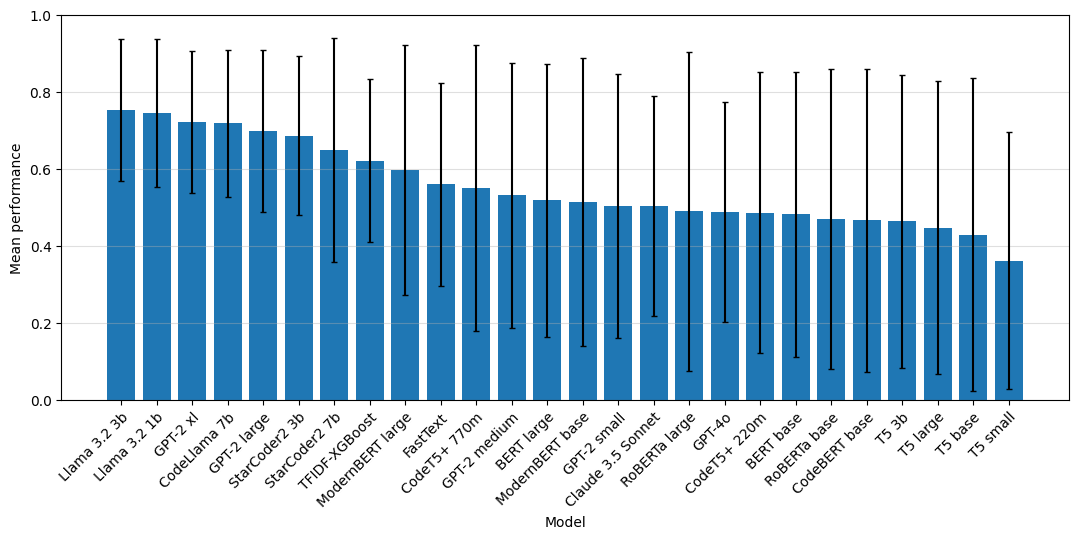

In [16]:
plt.figure(figsize=(13, 5))
plt.bar(
    df.index,
    df["mean"],
    yerr=df[["ci_lower", "ci_upper"]].T,
    capsize=2,
    align="center"
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.grid(axis="y", alpha=.4)
plt.ylabel("Mean performance")
plt.xlabel("Model")
plt.ylim([0, 1])
plt.show()

### Plot posterior matrix

In [17]:
# result.posterior_matrix

In [18]:
posterior_matrix_smaller_df = pd.DataFrame(np.nan, index=result.posterior_matrix.index, columns=result.posterior_matrix.columns)
posterior_matrix_equal_df = pd.DataFrame(np.nan, index=result.posterior_matrix.index, columns=result.posterior_matrix.columns)
posterior_matrix_larger_df = pd.DataFrame(np.nan, index=result.posterior_matrix.index, columns=result.posterior_matrix.columns)
posterior_matrix_inconclusive_df = pd.DataFrame(np.nan, index=result.posterior_matrix.index, columns=result.posterior_matrix.columns)
posterior_matrix_decision_df = pd.DataFrame(np.nan, index=result.posterior_matrix.index, columns=result.posterior_matrix.columns)

for i in range(result.posterior_matrix.shape[0]):
    for j in range(result.posterior_matrix.shape[1]):
        if isinstance(result.posterior_matrix.iloc[i, j], tuple):
            p_smaller, p_equal, p_larger = result.posterior_matrix.iloc[i, j]
            posterior_matrix_smaller_df.iloc[i, j] = p_smaller
            posterior_matrix_equal_df.iloc[i, j] = p_equal
            posterior_matrix_larger_df.iloc[i, j] = p_larger
            posterior_matrix_inconclusive_df.iloc[i, j] = ((p_smaller < 0.95) & (p_equal < 0.95) & (p_larger < 0.95)).astype(int)

            decision = 0
            if p_smaller >= 0.95:
                decision = 3
            elif p_equal >= 0.95:
                decision = 2
            elif p_larger >= 0.95:
                decision = 1
            posterior_matrix_decision_df.iloc[i, j] = decision

/tmp/ipykernel_373718/956787903.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


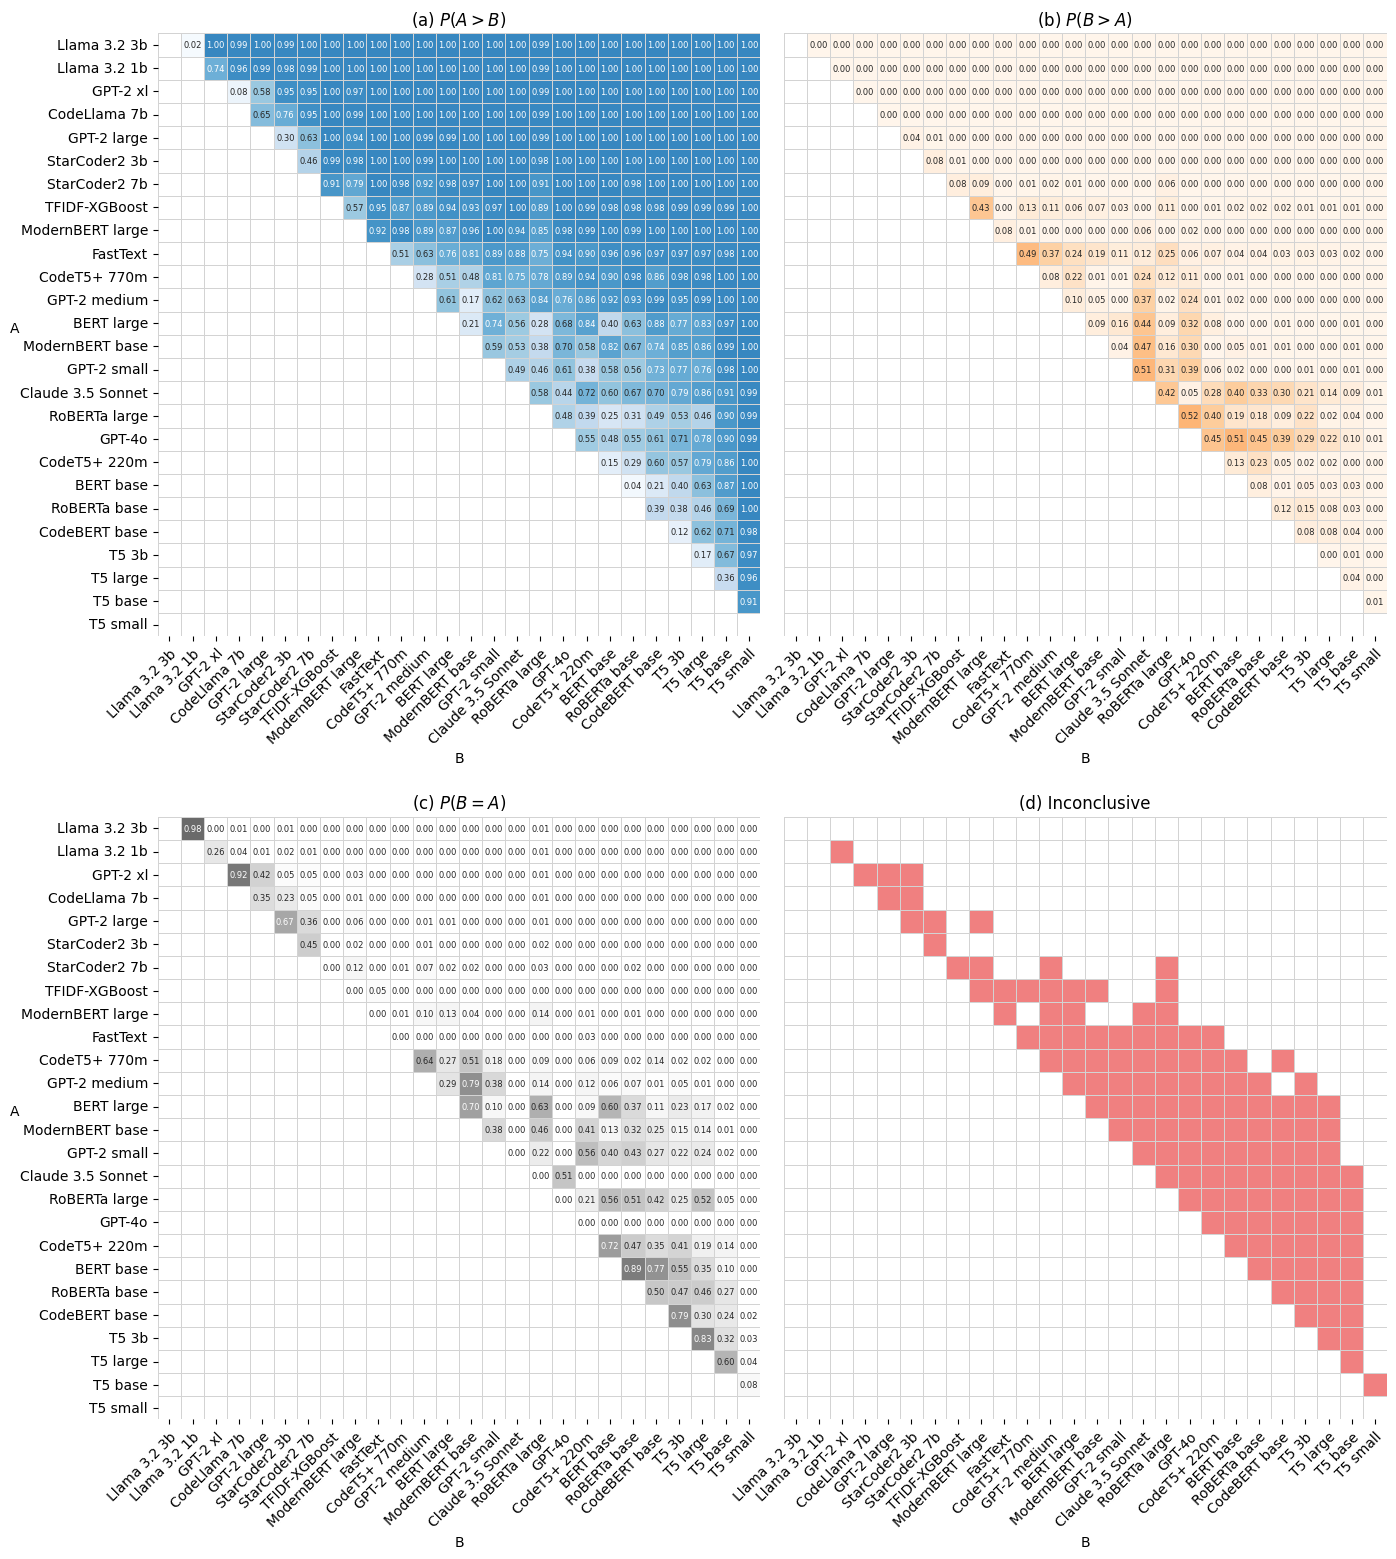

In [48]:
fig = plt.figure(figsize=(16, 18))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], wspace=0.02, hspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

sns.heatmap(
    posterior_matrix_smaller_df,
    vmin=0, vmax=1.5,
    cmap="Blues",
    annot=True, fmt=".2f", annot_kws={"fontsize": 6},
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax1
)
ax1.set_title("(a) $P(A > B)$")
ax1.set_xlabel("B")

ax1.set_ylabel("A", rotation=0)

sns.heatmap(
    posterior_matrix_larger_df,
    vmin=0, vmax=1.5,
    cmap="Oranges",
    annot=True, fmt=".2f", annot_kws={"fontsize": 6},
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax2
)
ax2.set_title("(b) $P(B > A)$")
ax2.set_xlabel("B")

# ax2.set_ylabel("A", rotation=0)
plt.setp(ax2.get_yticklabels(), visible=False)
# ax2.yaxis.tick_right()   # if you want ticks on the right but no labels, you can use this
ax2.yaxis.set_ticks_position("none")  # remove tick marks entirely
ax2.set_ylabel("")  # remove the “A” label

sns.heatmap(
    posterior_matrix_equal_df,
    vmin=0, vmax=1.5,
    cmap="Greys",
    annot=True, fmt=".2f", annot_kws={"fontsize": 6},
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax3
)
ax3.set_title("(c) $P(B = A)$")
ax3.set_xlabel("B")
ax3.set_ylabel("A", rotation=0)

sns.heatmap(
    posterior_matrix_inconclusive_df,
    vmin=0, vmax=1,
    cmap=ListedColormap(["white", "lightcoral"]),
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax4
)
ax4.set_title("(d) Inconclusive")
ax4.set_xlabel("B")

# ax4.set_ylabel("A", rotation=0)
plt.setp(ax4.get_yticklabels(), visible=False)
# ax4.yaxis.tick_right()   # if you want ticks on the right but no labels, you can use this
ax4.yaxis.set_ticks_position("none")  # remove tick marks entirely
ax4.set_ylabel("")  # remove the “A” label

plt.sca(ax1)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.sca(ax2)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.sca(ax3)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.sca(ax4)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()

plt.savefig("posterior_matrices.pdf", format="pdf", bbox_inches="tight")

plt.show()

/tmp/ipykernel_373718/2645855343.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


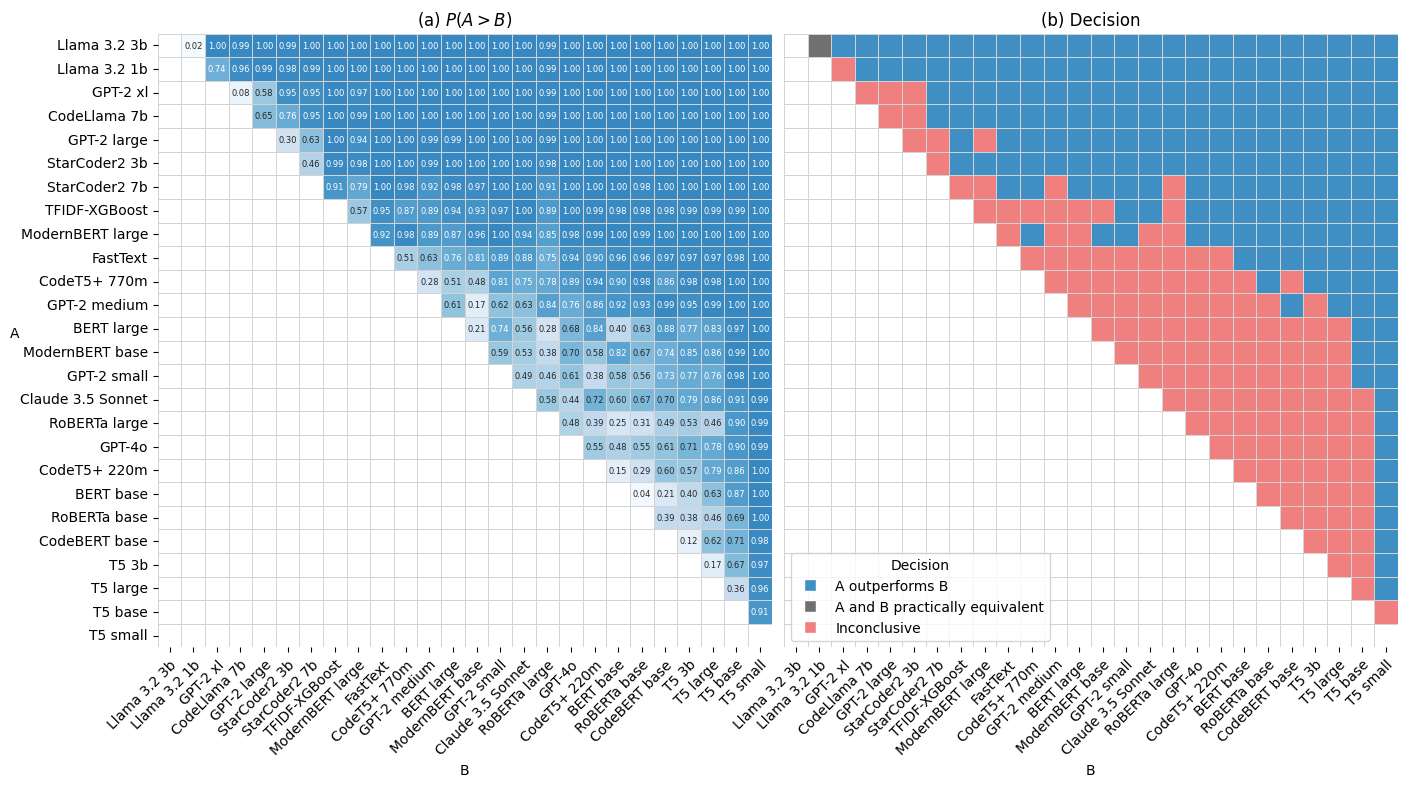

In [20]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.02)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)

sns.heatmap(
    posterior_matrix_smaller_df,
    vmin=0, vmax=1.5,
    cmap="Blues",
    annot=True, fmt=".2f", annot_kws={"fontsize": 6},
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax1
)
ax1.set_title("(a) $P(A > B)$")
ax1.set_xlabel("B")
ax1.set_ylabel("A", rotation=0)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

cmap = ListedColormap([
    "lightcoral",  # 0: inconclusive
    "#ef6612",  # 1: B > A
    "#707070",  # 2: tie
    "#3f8fc5",  # 3: A > B
])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm   = BoundaryNorm(bounds, cmap.N)

sns.heatmap(
    posterior_matrix_decision_df,
    #vmin=0, vmax=1,
    cmap=cmap, norm=norm,
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax2
)
ax2.set_title("(b) Decision")
ax2.set_xlabel("B")

# ax2.set_ylabel("A", rotation=0)
plt.setp(ax2.get_yticklabels(), visible=False)
# ax2.yaxis.tick_right()   # if you want ticks on the right but no labels, you can use this
ax2.yaxis.set_ticks_position("none")  # remove tick marks entirely
ax2.set_ylabel("")  # remove the “A” label

legend_handles = [
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#3f8fc5",  markersize=9, label="A outperforms B"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#707070",  markersize=9, label="A and B practically equivalent"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="lightcoral",  markersize=9, label="Inconclusive"),
]
ax2.legend(title="Decision", handles=legend_handles, loc="lower left")

plt.sca(ax1)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.sca(ax2)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()

plt.savefig("posterior_matrices_min.pdf", format="pdf", bbox_inches="tight")

plt.show()

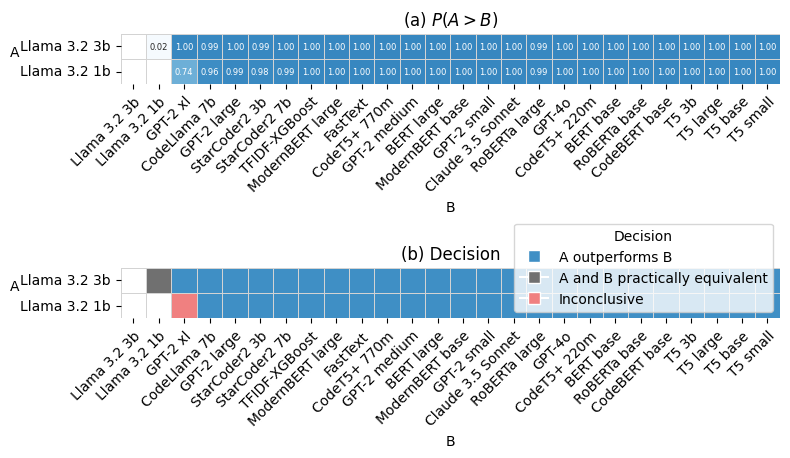

In [22]:
fig = plt.figure(figsize=(8, 5))
gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

sns.heatmap(
    posterior_matrix_smaller_df.iloc[:2],
    vmin=0, vmax=1.5,
    cmap="Blues",
    annot=True, fmt=".2f", annot_kws={"fontsize": 6},
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax1
)
ax1.set_title("(a) $P(A > B)$")
ax1.set_xlabel("B")
ax1.set_ylabel("A", rotation=0)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

cmap = ListedColormap([
    "lightcoral",  # 0: inconclusive
    "#ef6612",  # 1: B > A
    "#707070",  # 2: tie
    "#3f8fc5",  # 3: A > B
])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm   = BoundaryNorm(bounds, cmap.N)

sns.heatmap(
    posterior_matrix_decision_df.iloc[:2],
    #vmin=0, vmax=1,
    cmap=cmap, norm=norm,
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax2
)
ax2.set_title("(b) Decision")
ax2.set_xlabel("B")
ax2.set_ylabel("A", rotation=0)

legend_handles = [
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#3f8fc5",  markersize=9, label="A outperforms B"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#707070",  markersize=9, label="A and B practically equivalent"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="lightcoral",  markersize=9, label="Inconclusive"),
]
ax2.legend(title="Decision", handles=legend_handles, loc="lower right")

plt.sca(ax1)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.sca(ax2)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

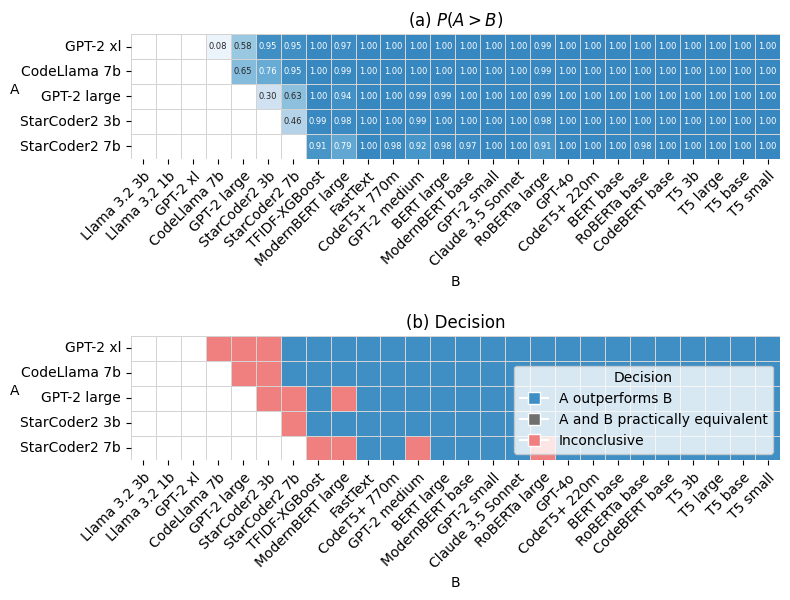

In [23]:
fig = plt.figure(figsize=(8, 6.5))
gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

sns.heatmap(
    posterior_matrix_smaller_df.iloc[2:7],
    vmin=0, vmax=1.5,
    cmap="Blues",
    annot=True, fmt=".2f", annot_kws={"fontsize": 6},
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax1
)
ax1.set_title("(a) $P(A > B)$")
ax1.set_xlabel("B")
ax1.set_ylabel("A", rotation=0)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

cmap = ListedColormap([
    "lightcoral",  # 0: inconclusive
    "#ef6612",  # 1: B > A
    "#707070",  # 2: tie
    "#3f8fc5",  # 3: A > B
])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm   = BoundaryNorm(bounds, cmap.N)

sns.heatmap(
    posterior_matrix_decision_df.iloc[2:7],
    #vmin=0, vmax=1,
    cmap=cmap, norm=norm,
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax2
)
ax2.set_title("(b) Decision")
ax2.set_xlabel("B")
ax2.set_ylabel("A", rotation=0)

legend_handles = [
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#3f8fc5",  markersize=9, label="A outperforms B"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#707070",  markersize=9, label="A and B practically equivalent"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="lightcoral",  markersize=9, label="Inconclusive"),
]
ax2.legend(title="Decision", handles=legend_handles, loc="lower right")

plt.sca(ax1)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.sca(ax2)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

In [24]:
posterior_matrix_smaller_df.iloc[7:18].mean(axis=None)

0.790249090909091

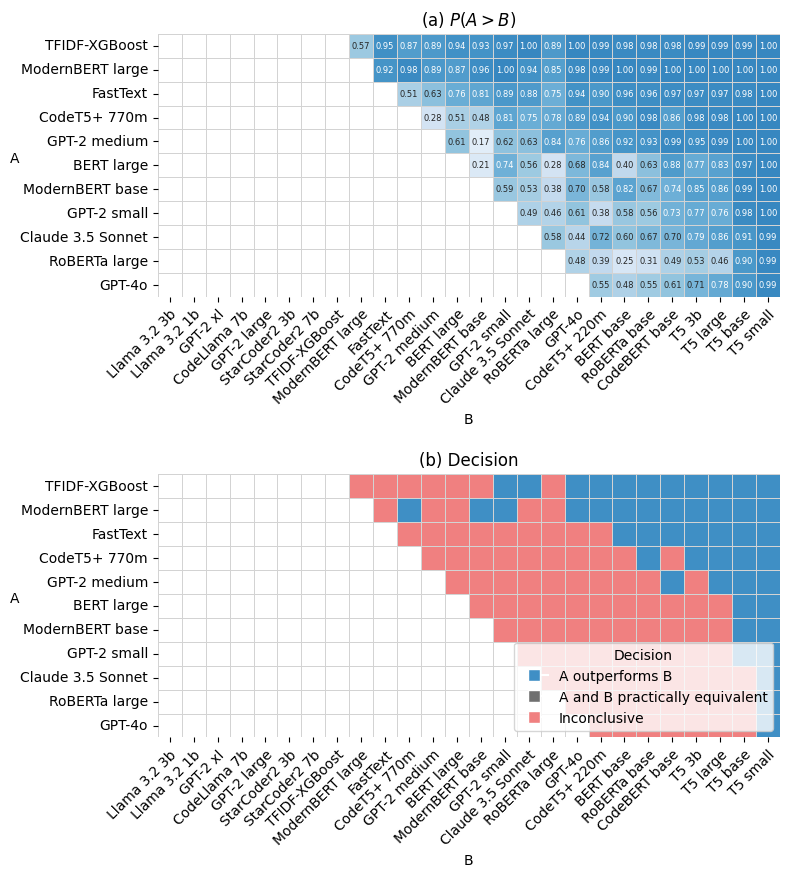

In [25]:
fig = plt.figure(figsize=(8, 9))
gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

sns.heatmap(
    posterior_matrix_smaller_df.iloc[7:18],
    vmin=0, vmax=1.5,
    cmap="Blues",
    annot=True, fmt=".2f", annot_kws={"fontsize": 6},
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax1
)
ax1.set_title("(a) $P(A > B)$")
ax1.set_xlabel("B")
ax1.set_ylabel("A", rotation=0)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

cmap = ListedColormap([
    "lightcoral",  # 0: inconclusive
    "#ef6612",  # 1: B > A
    "#707070",  # 2: tie
    "#3f8fc5",  # 3: A > B
])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm   = BoundaryNorm(bounds, cmap.N)

sns.heatmap(
    posterior_matrix_decision_df.iloc[7:18],
    #vmin=0, vmax=1,
    cmap=cmap, norm=norm,
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax2
)
ax2.set_title("(b) Decision")
ax2.set_xlabel("B")
ax2.set_ylabel("A", rotation=0)

legend_handles = [
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#3f8fc5",  markersize=9, label="A outperforms B"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#707070",  markersize=9, label="A and B practically equivalent"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="lightcoral",  markersize=9, label="Inconclusive"),
]
ax2.legend(title="Decision", handles=legend_handles, loc="lower right")

plt.sca(ax1)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.sca(ax2)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

In [26]:
posterior_matrix_smaller_df.iloc[18:].mean(axis=None)

0.5996678571428572

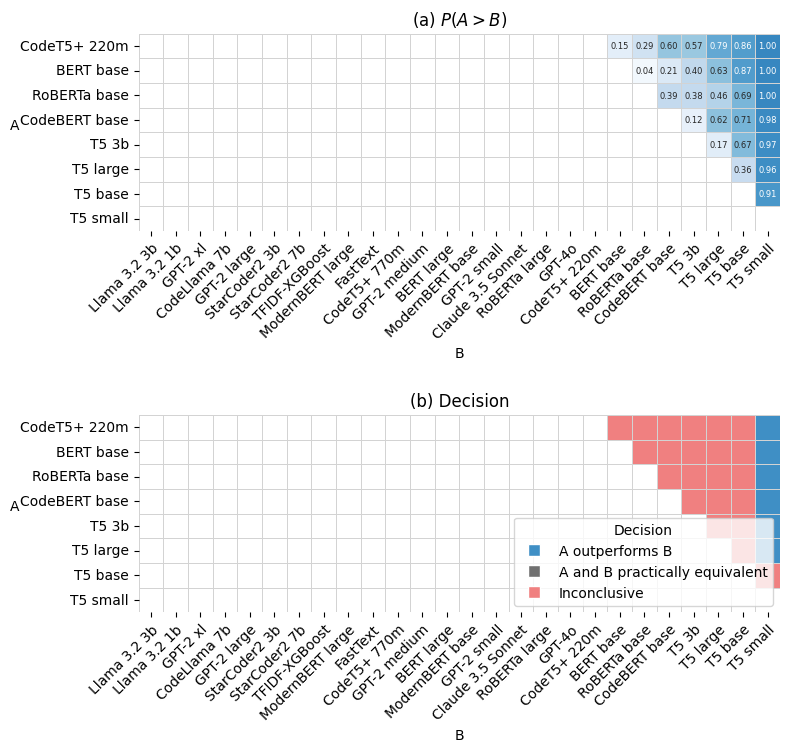

In [27]:
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

sns.heatmap(
    posterior_matrix_smaller_df.iloc[18:],
    vmin=0, vmax=1.5,
    cmap="Blues",
    annot=True, fmt=".2f", annot_kws={"fontsize": 6},
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax1
)
ax1.set_title("(a) $P(A > B)$")
ax1.set_xlabel("B")
ax1.set_ylabel("A", rotation=0)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

cmap = ListedColormap([
    "lightcoral",  # 0: inconclusive
    "#ef6612",  # 1: B > A
    "#707070",  # 2: tie
    "#3f8fc5",  # 3: A > B
])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm   = BoundaryNorm(bounds, cmap.N)

sns.heatmap(
    posterior_matrix_decision_df.iloc[18:],
    #vmin=0, vmax=1,
    cmap=cmap, norm=norm,
    linewidths=0.5, linecolor="lightgray",
    square=True, cbar=False,
    ax=ax2
)
ax2.set_title("(b) Decision")
ax2.set_xlabel("B")
ax2.set_ylabel("A", rotation=0)

legend_handles = [
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#3f8fc5",  markersize=9, label="A outperforms B"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="#707070",  markersize=9, label="A and B practically equivalent"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="lightcoral",  markersize=9, label="Inconclusive"),
]
ax2.legend(title="Decision", handles=legend_handles, loc="lower right")

plt.sca(ax1)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.sca(ax2)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()